# **1. INTRODUCTION**

======================================================================================================================================================================================================================================
# <center>Welcome to the Modelling Program File</center>


<center>This program aims to do sentiment analysis on text reviews given by Amazon customers. The sentiments are decided according to the product rating given by the customers which are divided into three categories: 0-2 = negative, 2-3 = neutral, 4-5 = positive. These sentiments are going to be the target value for the sentiment predictions. Note that this program was run on Google Colab.</center>


======================================================================================================================================================================================================================================

# 2. **IMPORT LIBRARIES**

In [6]:
# Import Libraries

# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# feature preprocessing
from sklearn.model_selection import train_test_split

# text preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

# model building
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding,Flatten,TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

# for model improvement
from tensorflow.keras.callbacks import EarlyStopping

# model evaluation
from sklearn.metrics import classification_report


In [7]:
# for initializing certification and allowing download of stopword
import certifi
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
nltk.data.path.append(certifi.where())

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3.**DATA LOADING**

In [10]:
# define file path
file_path = '/content/drive/My Drive/GC_7/1429_1.csv'

In [11]:
# load data, low_memory = False to address the issue of pandas classifying data with different types.
main_data = pd.read_csv(file_path)

# show first 5 data
main_data.head()

<ipython-input-11-5fa09a784453>:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  main_data = pd.read_csv(file_path)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [12]:
# show information of main data
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

### **INSIGHT:**

- Ada 34660 baris dengan 21 kolom. Namun, beberapa nilai kosong ada dalam kolom.
- Beberapa kolom dengan semua nilai kosong adalah: reviews.userCity dan reviews.userProvince.
- Baik reviews.id maupun reviews.didPurchase hanya memiliki 1 data non-null.
- Sementara beberapa kolom lain memiliki data tidak lengkap, di antaranya reviews.date (34621), reviews.doRecommend (34066), reviews.numHelpful (34131), reviews.rating (34627), reviews.text (34659), reviews.title(34654), reviews.username(34653).
- Sedangkan kolom-kolom dengan data lengkap adalah: id, brand, categories, keys, manufacturer,reviews.sourceURLs.

In [13]:
# cek data duplikat
main_data = main_data.drop_duplicates()

# cek
main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

### **INSIGHT:**

- No duplicate data.
- Note that for this study, some columns will be removed as they are not relevant in sentiment analysis measurements:
- 'id'
- 'name'
- 'asins'
- 'keys'
- 'reviews.date'
- 'reviews.dateAdded'
- 'reviews.dateSeen'
- 'reviews.didPurchase'
- 'reviews.doRecommend'
- 'reviews.id'
- 'reviews.numHelpful'
- 'reviews.sourceURLs'
- 'reviews.userCity'
- 'reviews.userProvince'
- 'reviews.username'

In [14]:
# data cleaning
# Remove all columns with null data, irrelevant columns for the study, and delete null values from other columns
# Copy dataset into a new variable
main_data2 = main_data.copy()

# drop irrelevant columns with null values
main_data2 = main_data2.drop([
'id',
'name',
'asins','keys','reviews.date',
'reviews.dateAdded',
'reviews.dateSeen',
'reviews.didPurchase',
'reviews.doRecommend',
'reviews.id',
'reviews.numHelpful','reviews.sourceURLs','reviews.userCity',
'reviews.userProvince',
 'reviews.username'], axis = 1)


# delete null data on the rest of the columns
main_data2 = main_data2.dropna()

# cek data
main_data2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34621 entries, 0 to 34659
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           34621 non-null  object 
 1   categories      34621 non-null  object 
 2   manufacturer    34621 non-null  object 
 3   reviews.rating  34621 non-null  float64
 4   reviews.text    34621 non-null  object 
 5   reviews.title   34621 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.8+ MB


### **INSIGHT:**

- The remaining columns to be used in this study are brand, categories, manufacturer, reviews.rating, reviews.text, reviews.title.
- The total data count is 34620, where only reviews.rating has numerical data type (float) while the others are strings.

In [15]:
# add new column called sentiment.value
main_data2['sentiment.value'] = np.where(main_data2['reviews.rating']<=2,'negative',
                                np.where((main_data2['reviews.rating']> 2) & (main_data2['reviews.rating'] <= 3),'neutral','positive' ))


# show first 10 data
main_data2.head(10)

,brand,categories,manufacturer,reviews.rating,reviews.text,reviews.title,sentiment.value
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,This product so far has not disappointed. My c...,Kindle,positive
1,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,great for beginner or experienced person. Boug...,very fast,positive
2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,positive
3,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,positive
4,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,positive
5,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,This amazon fire 8 inch tablet is the perfect ...,Just what we expected,positive
6,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,4.0,"Great for e-reading on the go, nice and light ...",great e-reader tablet,positive
7,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,"I gave this as a Christmas gift to my inlaws, ...",Great for gifts,positive
8,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,Great as a device to read books. I like that i...,Great for reading,positive
9,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,5.0,I love ordering books and reading them with th...,Great and lightweight reader,positive


### **INSIGHT:**

- column sentiment.value could be made based on the rating value.

# 4. **EXPLORATORY DATA ANALYSIS (EDA)**

## <u>Check Number of Data for Each Sentiment Value</u>
`Purpose`: To observe data distribution according to their sentiments.

`Method`: Pie Chart

In [16]:
# Group by 'sentiment.value' and count occurrences, renaming the count column
pie_data = pd.DataFrame(main_data2.groupby('sentiment.value').size().reset_index())
pie_data.columns = ['sentiment_value', 'count']  # Rename the columns as needed

In [17]:
# check column name created in the datafram
pie_data.columns.tolist()

['sentiment_value', 'count']

In [18]:
# define the function for calculating the percentages
def percentage_calculator(dataset,col_name):
    value_keeper = []
    for i in range(len(dataset)):
        calculate_value = dataset[col_name][i]/ sum(dataset[col_name])
        value_keeper.append(calculate_value)
    return value_keeper

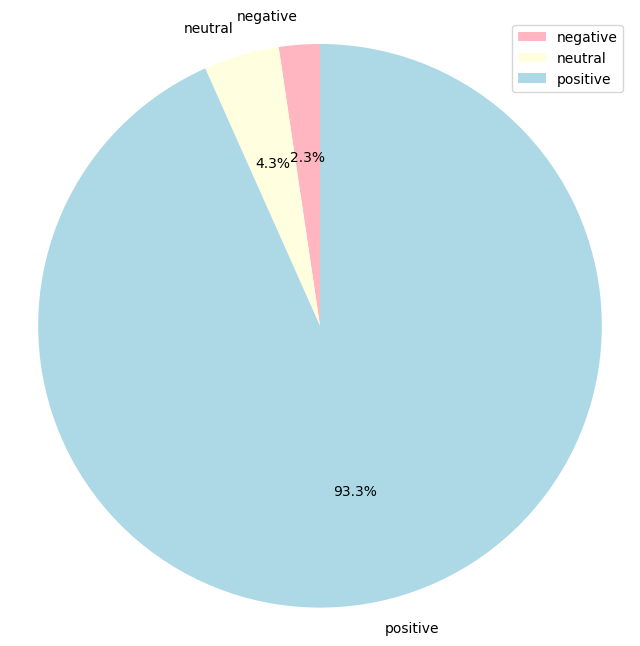

In [19]:
# define the label and their proportions
label = ['negative','neutral','positive']
proportions = percentage_calculator(pie_data,'count')


# plot
colors = ['lightpink','lightyellow','lightblue']
plt.figure(figsize=(8, 8))
plt.pie(proportions,labels = label, autopct ='%1.1f%%', startangle = 90,colors = colors)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.legend()

# show pie chart
plt.show()

### **INSIGHT:**
- The majority of the data has a positive sentiment type, accounting for 93.3%.
- Data with neutral sentiment type is 4.3%, while negative sentiment type is 2.3%.
- This means that products sold on Amazon have a good reputation.

## <u>Reducing Unique Values in Categories</u>
`Purpose`: To tailor less creation of word clouds based on sentiment to better suit the types of products being sold.
`Method` : make new column called new_categories then use wordcloud based on that.

In [21]:
# get the unique values of categories based on the manufacturer
unique_categories = main_data2.groupby('manufacturer')['categories'].unique()

# Iterate to display all the unique values
for manufacturer, categories in unique_categories.items():
    print(f"Manufacturer: {manufacturer}")
    print("Unique Categories:")
    for category in categories:
        print(category)
    print()

Manufacturer: Amazon
Unique Categories:
Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets
eBook Readers,Kindle E-readers,Computers & Tablets,E-Readers & Accessories,E-Readers
Electronics,eBook Readers & Accessories,Covers,Kindle Store,Amazon Device Accessories,Kindle E-Reader Accessories,Kindle (5th Generation) Accessories,Kindle (5th Generation) Covers
Tablets,Fire Tablets,Electronics,Computers,Computer Components,Hard Drives & Storage,Computers & Tablets,All Tablets
Tablets,Fire Tablets,Computers & Tablets,All Tablets
Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories
Electronics,iPad & Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,E-Readers & Accessories,E-Readers,Used:Computers Accessories,Used:Tablets,Computers,iPads Tablets,Kindle E-readers,Electronics Features
Fire Tablets,Tablets,Computers & Tablets,All

### **INSIGHT:**
- The unique categories of products are quite numerous, including both products produced by Amazon and Amazon Digital Services, Inc. Therefore, new categories should be created to compare the vocabulary that frequently appears based on the type of product category being sold.

### <u>DOMAIN KNOWLEDGE</u>:
- Products produced by Amazon and Amazon Digital Services, Inc. are mostly electronic products (Computers, iPad, Tablet, Electronics, Amazon Echo (smart electronics), Alexa (Amazon voice AI)), electronic accessories (phone accessories, devices, adapters/chargers, storage, cases, Kindle covers), Kindle products (eBooks, Kindle tablets), and other products (movies, Fire TV, tech toys, music).
- Therefore, the categorization of products is redefined with fewer types to ensure that the generated word clouds are more thematic based on the product category. Here are the revised categories:
    - 'Electronics'
    - 'Electronic Accessories'
    - 'Kindle Products'
    -  'Others'

### <u>Creation of New Categories:</u>

In [22]:
# create new name of the categories
new_name = ['Electronics', 'Kindle Products','Electronic Accessories']
# initiate new column
main_data2.insert(2,'new_categories','Others')
main_data2.loc[(main_data2['categories'].str.contains('Tablet'))|(main_data2['categories'].str.contains('Electronics'))|(main_data2['categories'].str.contains('iPad'))|(main_data2['categories'] == 'Computers')|(main_data2['categories'] == 'Alexa')|(main_data2['categories'] == 'Echo'), 'new_categories'] = new_name[0]
main_data2.loc[(main_data2['categories'].str.contains('Kindle'))|(main_data2['categories'].str.contains('Readers')), 'new_categories'] = new_name[1]
main_data2.loc[(main_data2['categories'].str.contains('Accessories'))|(main_data2['categories'].str.contains('Adapters'))|(main_data2['categories'].str.contains('Cases'))|(main_data2['categories'].str.contains('Covers'))|(main_data2['categories'].str.contains('Storage'))|(main_data2['categories'].str.contains('Chargers')), 'new_categories'] = new_name[2]


In [23]:
# confirm the number of unique values in new_categories
main_data2['new_categories'].unique()

array(['Electronics', 'Electronic Accessories', 'Kindle Products',
       'Others'], dtype=object)

### **INSIGHT:**
- New product categories have been successfully created, comprising 4 categories: 'Electronics', 'Electronic Accessories', 'Kindle Products', and 'Others'.

## <u>WordCloud based on Sentiment Values</u>
`Purpose`: To identify words that frequently appear at a certain sentiment value.

`Method`: Wordcloud.

In [24]:
# creating a function to remove brand names, leaving only the comments visible
def remove_words(semua_komentar, hapus_kata):
    for word in hapus_kata:
        semua_komentar = semua_komentar.replace(word, "")
    return semua_komentar

In [25]:
def wordcloud_sentiment_based(dataset,col_name,sentiment_type):
    data_sentiment_type = dataset[dataset[col_name]==sentiment_type]
# To create a list containing the types of manufacturers available in the dataset. The purpose is to tailor the word cloud according to the context of the product types.
    grouping_new_categories = dataset['new_categories'].unique().tolist()
    for category in grouping_new_categories:
        # keep data review text for making the word cloud
        wordcloud_data = data_sentiment_type['reviews.text']
        # join it as a string
        string_wordcloud = ' '.join(str(item) for item in wordcloud_data.tolist())

        # menghapus nama dan jenis barang supaya komentar saja yang terlihat
        vocab_delete = ['Amazon','Kindle','tablet','Fire','app','Echo','Alexa','TV']
        string_wordcloud_new = remove_words(string_wordcloud, vocab_delete)

        # print nama category untuk tiap wordcloud
        print(f"Wordcloud untuk tipe sentiment {sentiment_type} untuk tipe kategori produk {category.upper()}")

        # Ciptakan wordcloud
        word_cloud_diagram = WordCloud(width=800, height=400, background_color='white',colormap='Pastel2').generate(string_wordcloud_new)

        # Plot wordcloud
        plt.figure(figsize=(10, 5))

        # plt.imshow untuk display gambar
        # bilinear untuks smoothing dan resize ukuran gambar
        plt.imshow(word_cloud_diagram, interpolation='bilinear')

        # axis ditiadakan pada pinggiran wordcloud
        plt.axis('off')
        plt.show()


### 1. Wordcloud for positive sentiment

Wordcloud untuk tipe sentiment positive untuk tipe kategori produk ELECTRONICS


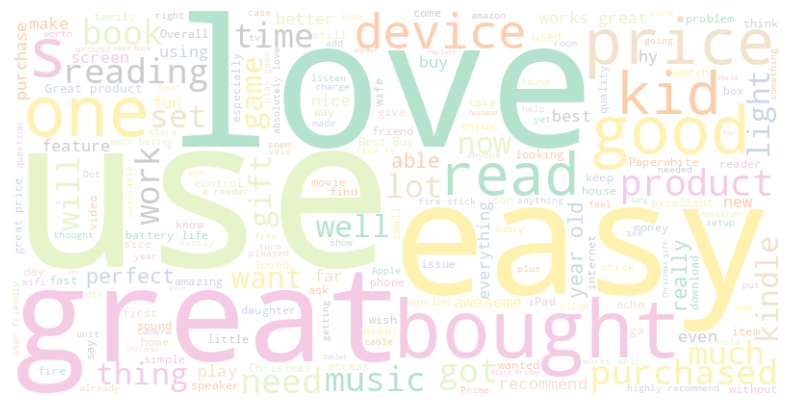

Wordcloud untuk tipe sentiment positive untuk tipe kategori produk ELECTRONIC ACCESSORIES


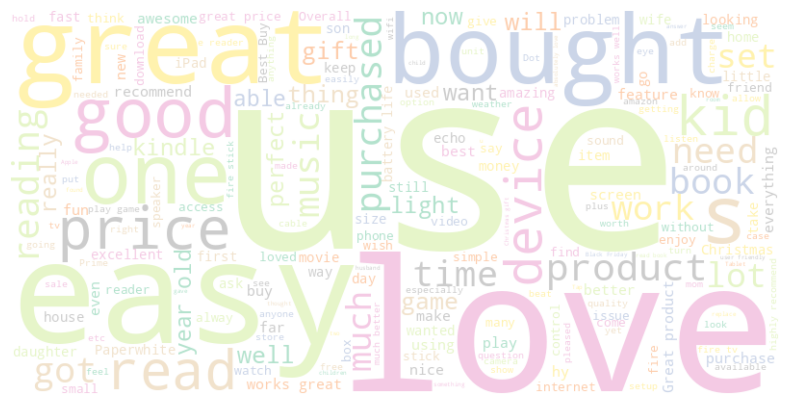

Wordcloud untuk tipe sentiment positive untuk tipe kategori produk KINDLE PRODUCTS


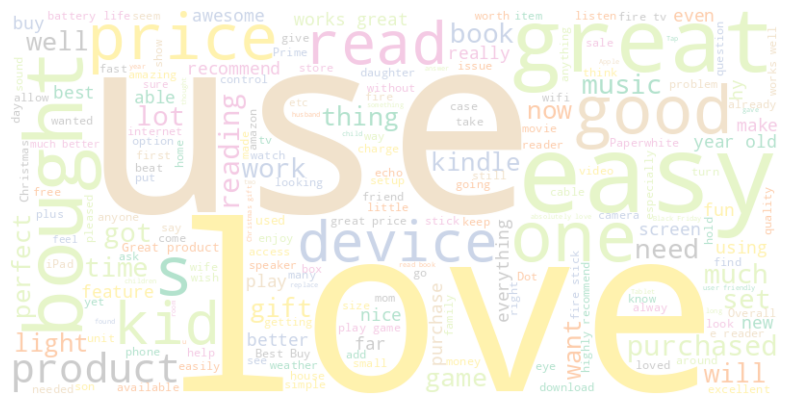

Wordcloud untuk tipe sentiment positive untuk tipe kategori produk OTHERS


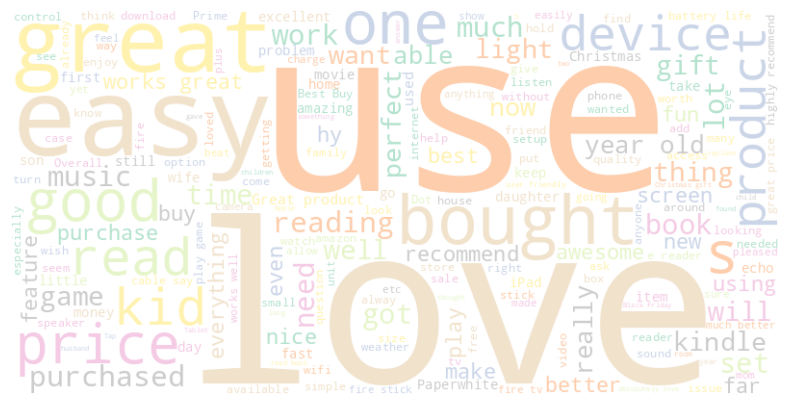

In [26]:
# call function
wordcloud_sentiment_based(main_data2,'sentiment.value','positive')

### **INSIGHT:**
- The vocabulary that often appears for positive sentiment in 4 types of product categories sold on Amazon are:
    1. love
    2. use
    3. easy
    4. great
    5. good
    6. product
    7. bought
    8. kid

### 2. Wordcloud for neutral sentiment

Wordcloud untuk tipe sentiment neutral untuk tipe kategori produk ELECTRONICS


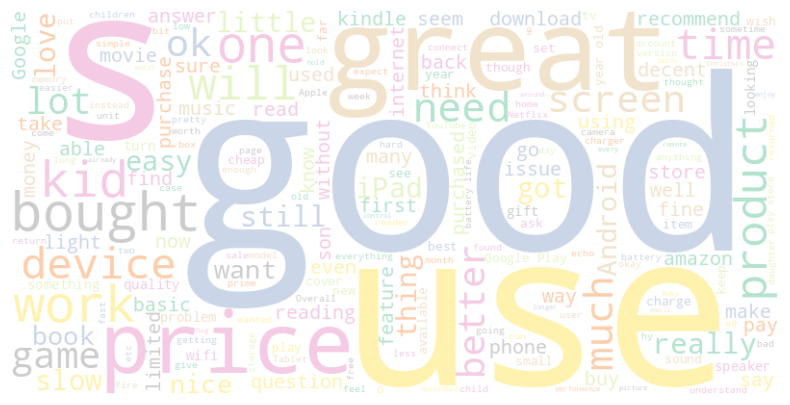

Wordcloud untuk tipe sentiment neutral untuk tipe kategori produk ELECTRONIC ACCESSORIES


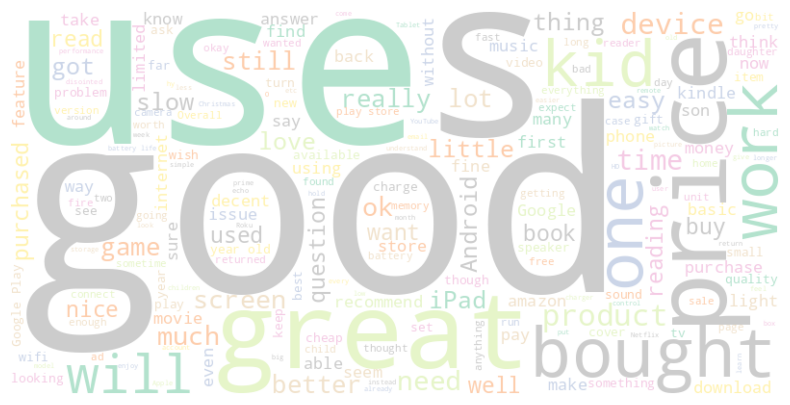

Wordcloud untuk tipe sentiment neutral untuk tipe kategori produk KINDLE PRODUCTS


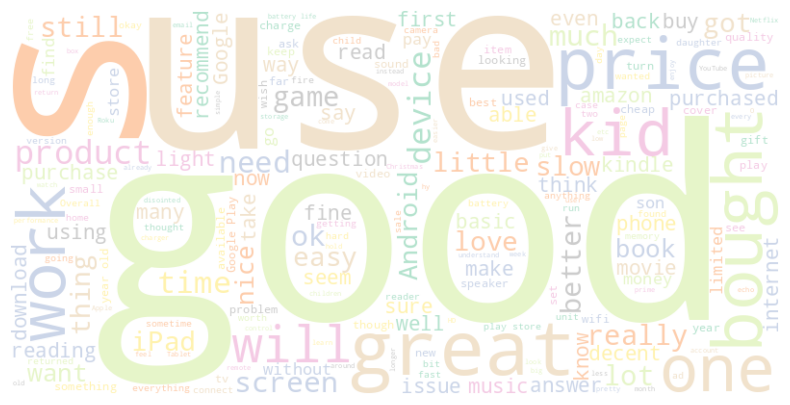

Wordcloud untuk tipe sentiment neutral untuk tipe kategori produk OTHERS


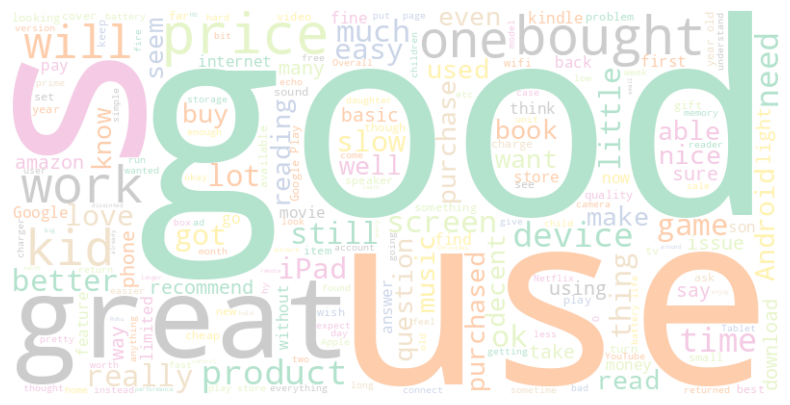

In [27]:
# panggil fungsi
wordcloud_sentiment_based(main_data2,'sentiment.value','neutral')

### **INSIGHT:**
- The vocabulary that often appears for positive sentiment on 4 types of product categories sold on Amazon are:
    1. good
    2. use
    3. price
    4. great
    5. work
    6. game
    7. kid
    8. device

- Compared to positive sentiment, neutral sentiment has the dominant vocab 'good'.

### 3. Wordcloud for negative sentiment

Wordcloud untuk tipe sentiment negative untuk tipe kategori produk ELECTRONICS


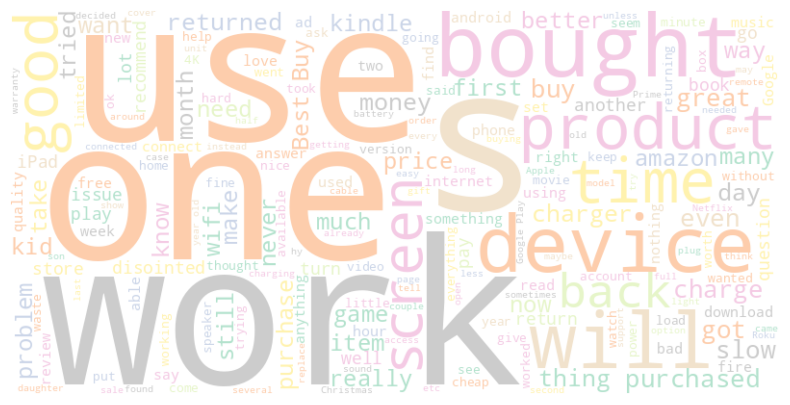

Wordcloud untuk tipe sentiment negative untuk tipe kategori produk ELECTRONIC ACCESSORIES


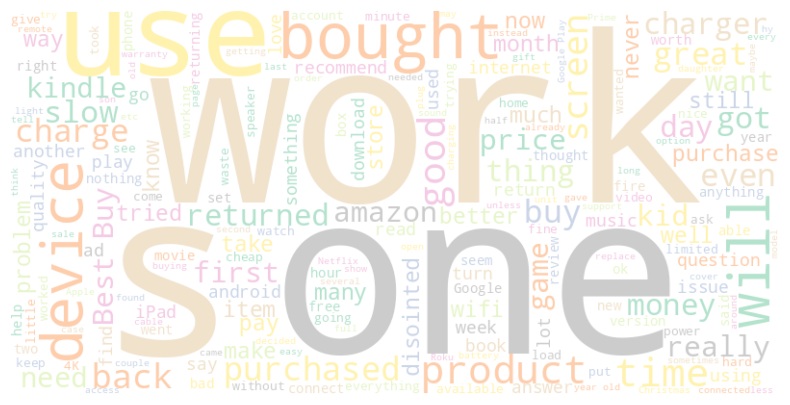

Wordcloud untuk tipe sentiment negative untuk tipe kategori produk KINDLE PRODUCTS


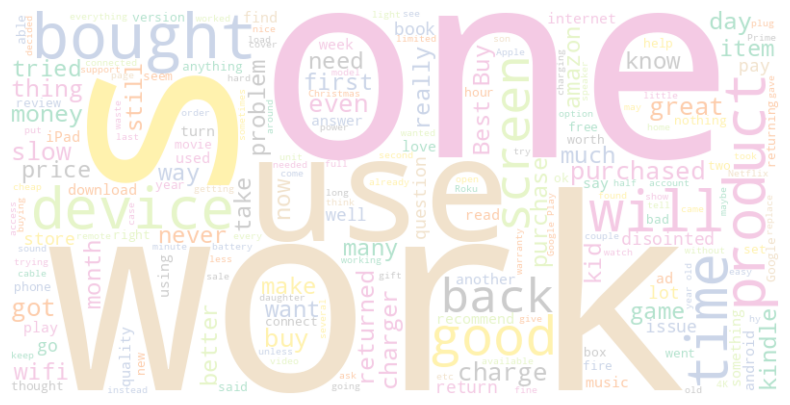

Wordcloud untuk tipe sentiment negative untuk tipe kategori produk OTHERS


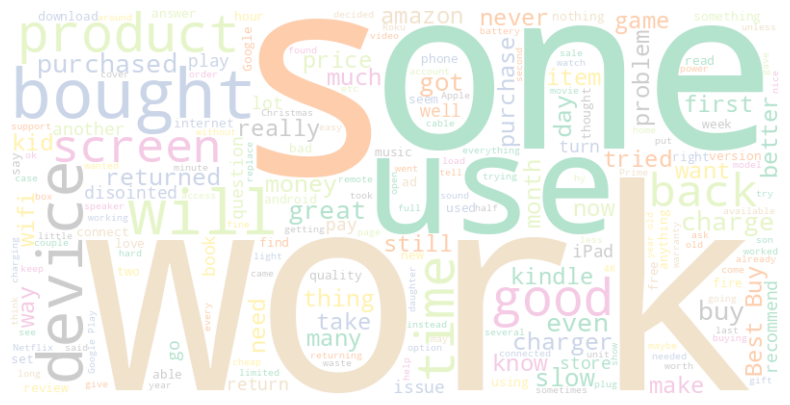

In [28]:
# call function
wordcloud_sentiment_based(main_data2,'sentiment.value','negative')

### **INSIGHT:**
- The vocabulary that often appears for negative sentiment in 4 types of product categories sold on Amazon are:
    1. work
    2. one
    3. use
    4. returned
    5. slow
    6. problem
    7. device
    8. bought

- Compared to positive and neutral sentiment, negative sentiment has a vocabulary that is less representative of the buyer's impression. The words work, one, bought, device, and use do not give a negative impression. So, other vocabulary words that describe negative values are included such as slow, problem, and returned.

# **5. FEATURE ENGINEERING**

## `Text Preprocessing`
- Removing useless words such as extra whitespaces, urls, newlines, mentions, and stopwords.

In [29]:
# call stopword
nltk.download('stopwords')
# for tokenization and download stopwords
nltk.download('punkt')
# keep english stopwords
stopwords_en = stopwords.words("english")
print('Stopwords from NLTK')
print(len(stopwords_en), stopwords_en)
print('')


# Create A New Set of Stopwords 
# add some words which too often come out in the wordcloud
new_stop_words = ['one','kid','amazon','kindle','tablet','fire','app','echo','alexa','tv','s']

## Merge Stopwords
stopwords_en = stopwords_en + new_stop_words
stopwords_en = list(set(stopwords_en))

print('Final stopwords from NLTK')
print(len(stopwords_en), stopwords_en)
print('')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Stopwords from NLTK
179 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',

In [32]:
# make function with text preporcessing
def text_preprocessing(filtered_dataset, stopwords):
    # conversion of all texts in reviews.text to lowercase
    text = filtered_dataset['reviews.text'].apply(lambda x: x.lower())

    # remove mention
    text = text.apply(lambda x: re.sub("@[A-Za-z0-9_]+", " ", x))

    # remove hashtag
    text = text.apply(lambda x: re.sub("#[A-Za-z0-9_]+", " ", x))

    # remove new line
    text = text.apply(lambda x: re.sub(r"\\n", " ", x))

    # remove whitespaces
    text = text.apply(lambda x: x.strip())

    # remove URL
    text = text.apply(lambda x: re.sub(r"http\S+", " ", x))
    text = text.apply(lambda x: re.sub(r"www.\S+", " ", x))

    # remove emoticon and symbol
    text = text.apply(lambda x: re.sub("[^A-Za-z\s']", " ", x))

    # apply tokenization
    tokens = text.apply(lambda x: word_tokenize(x))

    # remove stopwords
    tokens = tokens.apply(lambda x: [word for word in x if word not in stopwords])

    # combine token
    text = tokens.apply(lambda x: ' '.join(x))

    return text


In [33]:
# implement the function
main_data2['reviews.text.processed'] = text_preprocessing(main_data2, stopwords_en)

# show dataframe
main_data2

,brand,categories,new_categories,manufacturer,reviews.rating,reviews.text,reviews.title,sentiment.value,reviews.text.processed
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Amazon,5.0,This product so far has not disappointed. My c...,Kindle,positive,product far disappointed children love use lik...
1,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Amazon,5.0,great for beginner or experienced person. Boug...,very fast,positive,great beginner experienced person bought gift ...
2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Amazon,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,positive,inexpensive use learn step nabi thrilled learn...
3,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Amazon,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,positive,'ve hd two weeks love great value prime member...
4,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,Amazon,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,positive,bought grand daughter comes visit set user ent...
...,...,...,...,...,...,...,...,...,...
34655,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",Electronic Accessories,"Amazon Digital Services, Inc",3.0,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...,neutral,appreciably faster higher amp charger used hd ...
34656,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",Electronic Accessories,"Amazon Digital Services, Inc",1.0,Amazon should include this charger with the Ki...,Should be included,negative,include charger fact 're charging us extra som...
34657,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",Electronic Accessories,"Amazon Digital Services, Inc",1.0,Love my Kindle Fire but I am really disappoint...,Disappointing Charger,negative,love really disappointed power fast charging u...
34658,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",Electronic Accessories,"Amazon Digital Services, Inc",1.0,I was surprised to find it did not come with a...,Not worth the money,negative,surprised find come type charging cords purcha...


In [34]:
# show original data
main_data2.iloc[0]['reviews.text']

'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'

In [35]:
# show text processing result
main_data2.iloc[0]['reviews.text.processed']

'product far disappointed children love use like ability monitor control content see ease'

### **INSIGHT:**
- Words were successfully deleted.

## i. <u>Feature Creation</u>
- Splitting the dataset into 3 sets: train, validation, and test sets.
- Converting sentiment values into numeric form.

In [36]:
# Change Target into Number

main_data2['sentiment.value'] = main_data2['sentiment.value'].replace({'negative' : 0, 'neutral' : 1, 'positive' : 2})


main_data2['sentiment.value'].unique()

array([2, 0, 1])

In [37]:
# define X and y
X = main_data2['reviews.text.processed']
y = main_data2['sentiment.value']
# splitting datatset
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (26484,)
Val Size   :  (2943,)
Test Size  :  (5194,)


### **INSIGHT:**
- The amount of data for train is 26484, validation data is 2943, while for test is 5193.

## ii. <u>Feature Extraction, Transformation, dan Selection</u>
- Encoding sentiment type (target variable)
- Metode: one hot encoding since negative, neutral, dan positive do not have order relationship.

### **a. Encoding target variable:**

In [38]:
# proses encoding variable dengan one hot encode
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

# show result
y_train_ohe

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

### **INSIGHT:**
- encoding was successful.

# **6. ANN Training (Sequential API)**

### `vi.1. Model definition`

The ANN model has many layers divided into 3: input layer, hidden layer, and output layer. This set of modeling layers includes:

**INPUT LAYER**
- Text Vectorization Layer: This layer most likely aims to convert text into vectors that can be further processed.

- Embedding Layer: This layer is responsible for mapping the vector of words into a dense latent space.

**HIDDEN LAYER**
- Flatten Layer: This layer converts the data tensor into a one-dimensional array, so that it can be connected to the Dense layers.

- Dense layers: There are 4 dense layers with various number of units (128, 64, 32, and 16). The activation function used in these layers is ReLU (Rectified Linear Unit), which helps in overcoming the vanishing gradient problem.

**OUTPUT LAYER**
- Output Layer: This layer has 3 units and uses softmax activation function, as this model serves as a multiclass classification. Weight initialization is done using Glorot Normal initialization.

**MODEL COMPILATION**
- The model is compiled using categorical crossentropy loss function and Adam's optimizer. The metrics used for model performance evaluation is accuracy.

### `vi.2. Model Training`

#### a. **Check Number of Vocabularies and Tokens**

In [39]:
# CountVectorizer with Stopwords
cv_sw = CountVectorizer()
# fit pada training set
cv_sw.fit(X_train)

# transform all
X_train_cv_sw = cv_sw.transform(X_train)
X_test_cv_sw = cv_sw.transform(X_test)

# show transformation result
X_train_cv_sw

<26484x11749 sparse matrix of type '<class 'numpy.int64'>'
	with 344929 stored elements in Compressed Sparse Row format>

In [40]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab_sw = len(cv_sw.vocabulary_.keys())
max_sen_len_sw = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab_sw)
print('Maximum Sentence Length : ', max_sen_len_sw, 'tokens')

Total Vocab :  11749
Maximum Sentence Length :  970 tokens


#### b. **Text Vectorization**

In [41]:
# Set random seed for reproducibility
np.random.seed(20)
tf.random.set_seed(20)

# setting up untuk text vectorization

text_vectorization_sw = TextVectorization(max_tokens=total_vocab_sw,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len_sw,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization_sw.adapt(X_train)

In [42]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization_sw.get_vocabulary()[:20]

['',
 '[UNK]',
 'great',
 'use',
 'love',
 'easy',
 's',
 'nt',
 'bought',
 'good',
 'price',
 'like',
 'product',
 'would',
 'works',
 'get',
 'music',
 'much',
 'read',
 'kids']

### **INSIGHT:**

* Here are the results of text vectorization after the implementation of stopwords:
  - Total value: 26484 * 11749 = 311,309,116
  - Total non-zero values: 344,929 
  - Percentage : (568,863/286,276,242) or 0.11 %
  - Total vocabulary : 11749

* The 20 most frequently occurring vocabularies in the dataset are:

      1. [UNK], 
      2. 'great', 
      3. 'use', 
      4. 'love', 
      5. 'easy', 
      6. 's', 
      7. 'nt', 
      8. 'bought', 
      9. 'good', 
      10. 'price', 
      11. 'like', 
      12. 'product', 
      13. 'would', 
      14. 'works', 
      15. 'get', 
      16. 'music', 
      17. 'much', 
      18. 'read', 
      19. 'kids'

#### c. **Embedding**

In [43]:
# Embedding
embedding_process = Embedding(input_dim=total_vocab_sw,
                      output_dim=200,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len_sw)

In [44]:
# embedding result

## Sample dokumen
print('Sample dokumen')
print(main_data2['reviews.text.processed'][0])
print('')

## Result of Text Vectorization
print('Text Vectorization Result')
print(text_vectorization_sw([main_data2['reviews.text.processed'][0]]))
print('Vector SIze : ', text_vectorization_sw([main_data2['reviews.text.processed'][0]]).shape)
print('')

## Result of  Embedding
print('Embedding')
print(embedding_process(text_vectorization_sw([main_data2['reviews.text.processed'][0]])))
print('Vector size : ', embedding_process(text_vectorization_sw([main_data2['reviews.text.processed'][0]])).shape)

Contoh dokumen
product far disappointed children love use like ability monitor control content see ease

Hasil Text Vectorization
tf.Tensor(
[[  12   81  447  202    4    3   11  298 1459  130  211  160  314    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 

#### d. **Model Training**

In [45]:
# Clear session first
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define architecture ANN
relu_model = Sequential()
relu_model.add(text_vectorization_sw)
relu_model.add(embedding_process)
# convert tensor data into 1D array
relu_model.add(Flatten())
relu_model.add(Dense(128, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
relu_model.add(Dense(64, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
relu_model.add(Dense(32, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
relu_model.add(Dense(16, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
# output layer (karna diencode targetnya, terdapat 3 kolom sehingga menggunakan softmax)
relu_model.add(Dense(3, activation='softmax',kernel_initializer= tf.keras.initializers.GlorotNormal(seed)))
# compile
relu_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# show ANN result
relu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 970)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 970, 200)          2349800   
                                                                 
 flatten (Flatten)           (None, 194000)            0         
                                                                 
 dense (Dense)               (None, 128)               24832128  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                        

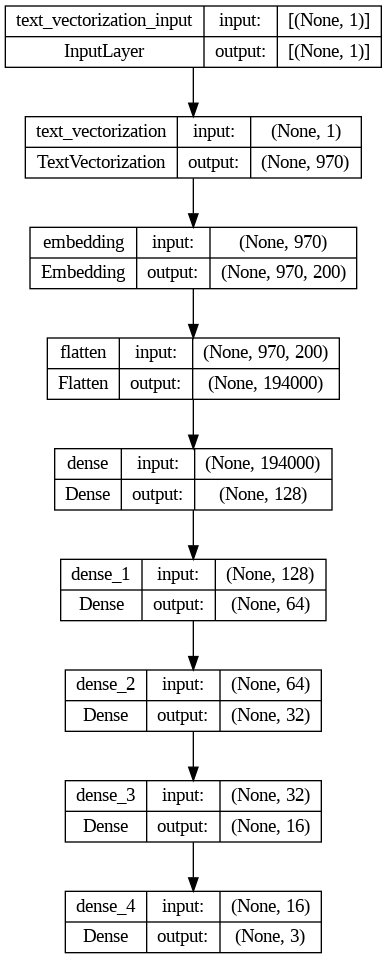

In [46]:
# Plot layers
tf.keras.utils.plot_model(relu_model, show_shapes=True)

In [47]:
# model training
relu_model_model_result = relu_model.fit(X_train, y_train_ohe, epochs=10, validation_data=(X_val, y_val_ohe),batch_size=50,shuffle = False)

Epoch 1/10
530/530 [==============================] - 44s 78ms/step - loss: 0.2476 - accuracy: 0.9343 - val_loss: 0.2201 - val_accuracy: 0.9368
Epoch 2/10
530/530 [==============================] - 7s 14ms/step - loss: 0.1626 - accuracy: 0.9454 - val_loss: 0.2421 - val_accuracy: 0.9344
Epoch 3/10
530/530 [==============================] - 8s 14ms/step - loss: 0.1016 - accuracy: 0.9650 - val_loss: 0.2956 - val_accuracy: 0.9188
Epoch 4/10
530/530 [==============================] - 7s 14ms/step - loss: 0.0685 - accuracy: 0.9773 - val_loss: 0.3752 - val_accuracy: 0.9137
Epoch 5/10
530/530 [==============================] - 8s 14ms/step - loss: 0.0444 - accuracy: 0.9857 - val_loss: 0.4038 - val_accuracy: 0.9123
Epoch 6/10
530/530 [==============================] - 8s 14ms/step - loss: 0.0294 - accuracy: 0.9912 - val_loss: 0.3752 - val_accuracy: 0.9256
Epoch 7/10
530/530 [==============================] - 7s 14ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.5744 - val_accuracy: 0.929

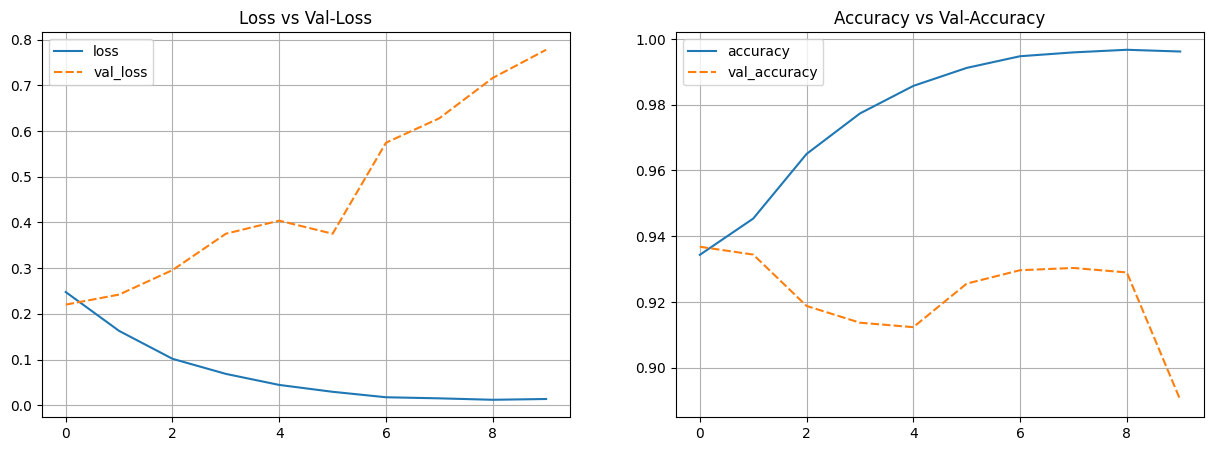

In [48]:
# Plot training result
nlp_relu_seq_df = pd.DataFrame(relu_model_model_result.history)

# plotting process
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=nlp_relu_seq_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=nlp_relu_seq_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

### **INSIGHT:**

- Model overfitting because the accuracy in the train set is greater than the validation set (highest: (train) 0.99 > 0.(val) 93), as well as the difference between average loss and validation loss (furthest difference = 0.7641).

- Validation loss increases as the number of epochs increases. Whereas, the train loss is better (decreasing).

- Calculate the average loss difference between training and validation:
      (0.0275 + 0.0795 + 0.194 + 0.3067 + 0.3594 + 0.3458 + 0.557 + 0.6129 + 0.7042 + 0.7641) / 10 => 0.39511

### `vi.3. Model Evaluation`
`Evaluation Metrics`: f1-score.

`Reason`: considering the number of misclassification cases (precision and recall). This dataset is imbalanced so it is better to look at the classification performance for each category.

In [49]:
# Check the performance of test-set
class_names = ['negative','neutral','positive']
## Get the probability
y_pred_relu_proba = relu_model.predict(X_test)

## Get class with maximum probability
# argmax converts the values into class labels, axis = -1 indicates getting all the values until the last axis
y_pred_relu_proba = np.argmax(y_pred_relu_proba, axis=-1)

## Display Classification Report for True values
print(classification_report(y_test, y_pred_relu_proba, target_names=np.array(class_names)))

163/163 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

    negative       0.29      0.10      0.15       122
     neutral       0.15      0.28      0.20       225
    positive       0.96      0.93      0.94      4847

    accuracy                           0.89      5194
   macro avg       0.47      0.44      0.43      5194
weighted avg       0.91      0.89      0.89      5194



### **INSIGHT:**
- The model is good at identifying positive comment texts due to its high f1-score (0.97), followed by high recall (0.99) and precision (0.94).
- For the neutral category, the f1-score value is 0.07, where precision = 0.47 and very low recall = 0.07.
- Finally for the negative category, the f1-score value is 0.24, where precision = 0.35, while recall is at 0.18.
- Although the model has a high overall accuracy at 0.93, it struggles to identify neutral comment texts. This could be due to the use of similar vocabulary between the three sentiments.
- In addition, the training data for negative and neutral sentiments is much less than positive sentiments. (It is evident from the EDA that the amount of data with positive sentiment is 93.3%, however, neutral is 4.3%, and negative sentiment type is 2.3%.)

# **7. ANN Model Improvement**

- Due to model overfitting, dropout and early stopping methods can be implemented.

### `vii.1. Model definition`

The ANN model has many layers divided into 3: input layer, hidden layer, and output layer. This set of modeling layers includes:

**INPUT LAYER**
- Text Vectorization Layer: This layer most likely aims to convert text into vectors that can be further processed.

- Embedding Layer: This layer is responsible for mapping the vector of words into a dense latent space.

**HIDDEN LAYER**
- Flatten Layer: This layer converts the data tensor into a one-dimensional array, so that it can be connected to the Dense layers.

- Dense layers: There are 4 dense layers with various number of units (128, 64, 32, and 16). The activation function used in these layers is ReLU (Rectified Linear Unit), which helps in solving the vanishing gradient problem.

- In between each dense layer, a dropout layer is added that converts some neurons to 0 to make the model less complex.

**OUTPUT LAYER**
- Output Layer: This layer has 3 units and uses a softmax activation function, as this model serves as a multiclass classification. Weight initialization is done using Glorot Normal initialization.

**MODEL COMPILATION**
- The model is compiled using categorical crossentropy loss function and Adam's optimizer. The metrics used for model performance evaluation is accuracy.

**EARLY STOPPING**
- EarlyStopping is a callback function provided by Ker.

### `vii.2. Model Training`

In [55]:
# Clear session first
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Define architecture ANN
improved_model = Sequential()
improved_model.add(text_vectorization_sw)
improved_model.add(embedding_process)
# convert tensor data into 1D array
improved_model.add(Flatten())
improved_model.add(Dense(128, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
improved_model.add(Dropout(0.1, seed=seed))
improved_model.add(Dense(64, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
improved_model.add(Dropout(0.2, seed=seed))
improved_model.add(Dense(32, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
improved_model.add(Dropout(0.2, seed=seed))
improved_model.add(Dense(16, activation='relu', kernel_initializer= tf.keras.initializers.HeNormal(seed)))
improved_model.add(Dropout(0.1, seed=seed))
# output layer (karna diencode targetnya, terdapat 3 kolom sehingga menggunakan softmax)
improved_model.add(Dense(3, activation='softmax',kernel_initializer= tf.keras.initializers.GlorotNormal(seed)))
# compile
improved_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# show ANN result
improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 970)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 970, 200)          2349800   
                                                                 
 flatten (Flatten)           (None, 194000)            0         
                                                                 
 dense (Dense)               (None, 128)               24832128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

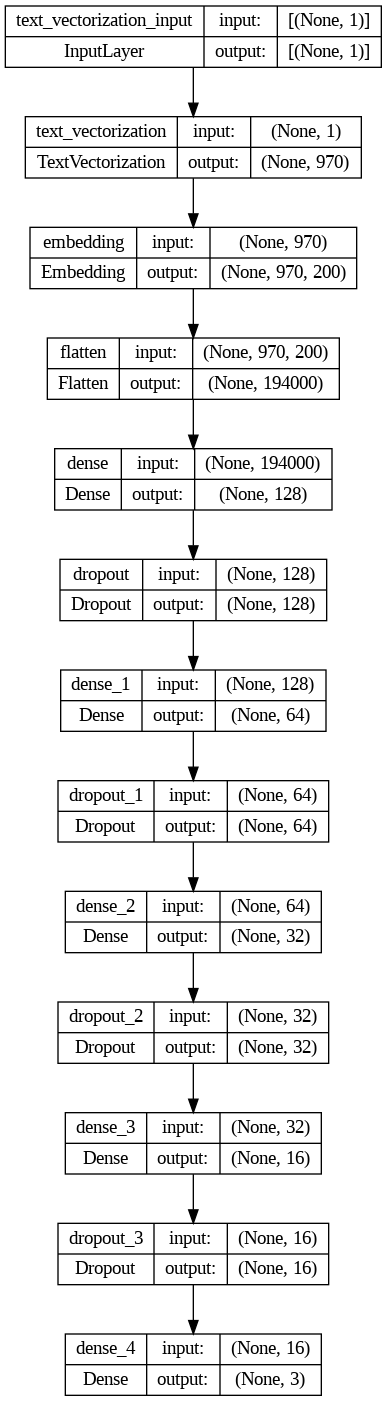

In [56]:
# Plot layers
tf.keras.utils.plot_model(improved_model, show_shapes=True)

In [57]:
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

nlp_relu_seq_improved = improved_model.fit(X_train,
                                   y_train_ohe,
                                   epochs=20,
                                   validation_data=(X_val, y_val_ohe),
                                   batch_size=20,callbacks=[early_stopping], shuffle = False)

Epoch 1/20
1325/1325 [==============================] - 39s 28ms/step - loss: 0.1223 - accuracy: 0.9577 - val_loss: 0.5956 - val_accuracy: 0.9201
Epoch 2/20
1325/1325 [==============================] - 17s 13ms/step - loss: 0.0603 - accuracy: 0.9801 - val_loss: 0.6105 - val_accuracy: 0.9218
Epoch 3/20
1325/1325 [==============================] - 17s 13ms/step - loss: 0.0402 - accuracy: 0.9882 - val_loss: 0.5191 - val_accuracy: 0.9042
Epoch 4/20
1325/1325 [==============================] - 17s 13ms/step - loss: 0.0326 - accuracy: 0.9907 - val_loss: 0.9362 - val_accuracy: 0.9300
Epoch 5/20
1325/1325 [==============================] - 17s 13ms/step - loss: 0.0242 - accuracy: 0.9932 - val_loss: 0.8703 - val_accuracy: 0.9232
Epoch 6/20
1325/1325 [==============================] - 17s 13ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 1.1046 - val_accuracy: 0.9320
Epoch 7/20
1325/1325 [==============================] - 17s 13ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.5226 -

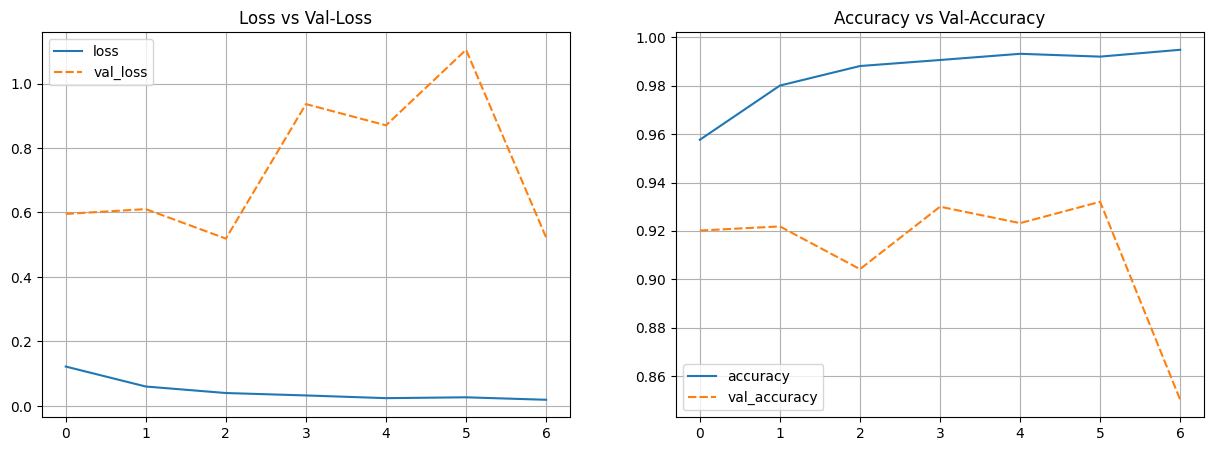

In [58]:
# Plot training result
nlp_relu_seq_improved_df = pd.DataFrame(nlp_relu_seq_improved.history)

# plotting process
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=nlp_relu_seq_improved_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=nlp_relu_seq_improved_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

### **INSIGHT:**

- The model is still overfitting because the accuracy in the train set is greater than the validation set (highest: (train) 0.99 > 0.(val) 93), as well as the difference between average loss and validation loss (furthest difference = 1.0777).

- The validation loss was more constant than before the model improvement (it increased to about 1, but dropped to 0.6). Meanwhile, the train loss is lower than before (closer to 0), indicating that the model is better at generalizing new/unseen data when making predictions.

- However, the average difference loss and validation loss are also getting bigger, here is the comparison:
  - average before model improvement: 0.39511
- Calculation of the average loss difference between training and validation:
      (0.4733 + 0.5502 + 0.4789 + 0.9036 + 0.8461 + 1.0777 + 0.5034) / 7 => 0.690



### `vii.3. Model Evaluation`

In [59]:
# Check the performance of test-set
class_names = ['negative','neutral','positive']
## Get the probability
y_pred_relu_improved = improved_model.predict(X_test)

## Get class with maximum probability
# argmax converts the values into class labels, axis = -1 indicates getting all the values until the last axis
y_pred_relu_improved = np.argmax(y_pred_relu_improved, axis=-1)

## Display Classification Report for True values
print(classification_report(y_test, y_pred_relu_improved, target_names=np.array(class_names)))

163/163 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

    negative       0.34      0.22      0.27       122
     neutral       0.17      0.21      0.19       225
    positive       0.95      0.95      0.95      4847

    accuracy                           0.90      5194
   macro avg       0.49      0.46      0.47      5194
weighted avg       0.91      0.90      0.90      5194



- The model has largely improved in identifying class categories because:
  - the f1-score value for positive sentiment increased from 0.94 to 0.95
  - the f1-score value for neutral sentiment decreased from 0.20 to 0.19
  - the f1-score value for negative sentiment increased from 0.15 to 0.27.
  
- Then, the overall accuracy also increased from 0.89 to 0.90.
- With the improved ability of the model to recognize negative sentiment, it can help Amazon's development by finding key words representing negative sentiment. In the end, Amazon can take comments with negative sentiment as input in improving services when delivering goods and maintaining the quality of goods production.


# **8. MODEL SAVING**

- The ANN improvement model is taken because it has better performance in identifying comment texts (reviews) that have negative sentiments.

- All of them are used as comments to avoid changing the contents of the saving model obtained from the analysis results.

In [60]:
# Freeze model

# improved_model.trainable = False
# improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 970)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 970, 200)          2349800   
                                                                 
 flatten (Flatten)           (None, 194000)            0         
                                                                 
 dense (Dense)               (None, 128)               24832128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [61]:
# save in tf form
# tf.keras.models.save_model(improved_model, '/content/drive/My Drive/GC_7/improved_model_tf')

# **10. CONCLUSION**

### **EDA**:
- Amazon has a positive brand image because the majority of its review texts are positive sentiment (around 93%).
- The wordcloud results for each data category provide information on the words used in each sentiment. If you notice, each sentiment shares some of the same word types, which may affect the model's decision making and determine the sentiment type of the review text.

### **METRICS EVALUATION AND MODELLING PROCESS:**
- Through plotting the training vs validation loss, it is concluded that the validation loss is more constant than before the use of the improvement model. On the other hand, the train loss is lower than before and also more constant. This indicates that the model is better at generalizing new/unseen data when making predictions.

- Based on the f1-score value, the model is able to identify text reviews that have positive sentiment values very well, but less well on negative sentiment and neutral sentiment.

- This is due to the model experiencing overfitting problems from the plotting accuracy vs validation accuracy results.

- Even after implementing dropout and earlystopping in the model improvement section, the model still shows overfitting in training but with a smaller difference in validation and training values. As a result, an improvement in f1-score performance in the negative sentiment category is seen (0.15 => 0.27).

### **STRENGTH AND WEAKNESS OF THE MODEL:**

- The advantage of the model is that it can distinguish negative, neutral, and positive sentiments based on the adjectives that represent these categories. For example: dissapointed, love, great, good.

- The weakness of the model is that it is unable to categorize sentences with the phrase "not" which is usually associated with negative sentiments. For example: 

  - not good,
  - not working well,
  - not useful, etc.

- This is due to the use of stopwords from nltk that remove the word 'not'. Due to limited time and device capabilities, the model could not be improved regarding the choice of stopwords.


### **MODEL IMPROVEMENT IDEAS:**
- Here's how to improve the model:
  - perform imbalanced dataset handling,
  - using other architecture models such as LSTM, GRU,
  - using more semantic embedding techniques (Word2Vec, GloVe, BER).
  - better sort out the words inside the stopwords so that the context of the sentence can be understood better. For example, won't => will not, shouldn't => should not, so that not can be stored as vocabulary while will and should do not need to be stored.